In [6]:
!pip install -U datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%%capture
!pip install  transformers==4.19.2
!pip install rouge_score

In [9]:
from datasets import load_metric
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/codecycle/WikiHow.csv')
df.head()

,title,heading,paragraph
0,How to Become a Superstar in the Sims Complete...,Load up your Complete Collection Sims game and...,"If possible, delete some of the Sims already i..."
1,How to Become a Superstar in the Sims Complete...,Create 4 separate 'Bachelor-type' Sims and mov...,NaN
2,How to Become a Superstar in the Sims Complete...,"Have them all study up on their Cooking, Chari...",You may need to use the 'rosebud;' cheat code ...
3,How to Become a Superstar in the Sims Complete...,Have them all meet each other and become friends.,You can do this by sending each of them to the...
4,How to Become a Superstar in the Sims Complete...,Go to Magic Town and buy some Diamond Dust and...,NaN


In [10]:
print(df.shape)
df = df.dropna()
print(df.shape)

(60190, 3)
(59485, 3)


In [11]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(59485, 3)
(49295, 3)


In [12]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

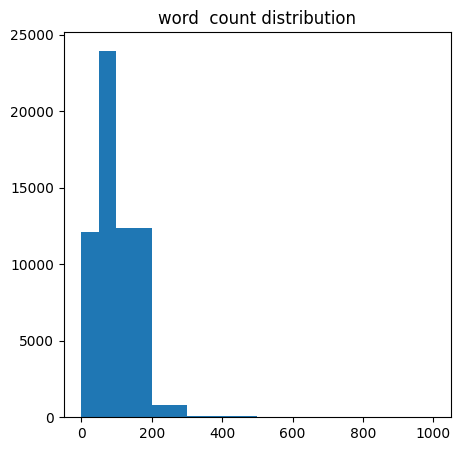

In [13]:
numofwords = df.length
from matplotlib import pyplot as plt

fig = plt.figure(figsize =(5,5))
plt.hist(numofwords.to_numpy(), bins = [0,50,100,200,300,500,1000])


plt.title("word  count distribution")

plt.show()

In [14]:
tempdf = df[df.length < 200]
print(tempdf.shape)

(48415, 4)


In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [16]:
max_input_length =1024
max_output_length = 64
batch_size = 16

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] =[
         [-100 if token == tokenizer.pad_token_id else token for token in labels]
         for labels in batch["labels"]
    ]
    return batch

In [17]:
import numpy as np
train,validate,test = np.split(tempdf.sample(frac=1, random_state=42), [int(.6*len(tempdf)), int(.7*len(tempdf))])
print(train.shape)
print(validate.shape)
print(test.shape)

(29049, 4)
(4841, 4)
(14525, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
validate = validate[:20]
validate.shape

(20, 4)

In [19]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)


train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)
validate_dataset = validate_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)

Map:   0%|          | 0/29049 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [20]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
validate_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [21]:
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384",gradient_checkpointing=True,use_cache=False)
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
rouge = load_metric("rouge")


def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure,4),
    }

from transformers import Seq2SeqTrainer , Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()
training_args = Seq2SeqTrainingArguments(
      predict_with_generate = True,
      evaluation_strategy = "steps",
      per_device_train_batch_size = batch_size,
      per_device_eval_batch_size = batch_size,
      output_dir = "./",
      logging_steps = 5,
      eval_steps = 10,
      save_steps = 10,
      save_total_limit = 2,
      gradient_accumulation_steps =4,
      num_train_epochs = 10
     )

trainer = Seq2SeqTrainer(
      model = led,
      args = training_args,
      compute_metrics = compute_metrics,
      train_dataset = train_dataset,
      eval_dataset = validate_dataset,
      tokenizer = tokenizer
  )

Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [22]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 29049
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 4540
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two vari

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,0.050100,0.044504,0.848100,0.253000,0.321300
20,0.009600,0.001307,0.991500,0.788900,0.848300
30,0.001900,0.000083,0.991500,0.988200,0.990000
40,0.003400,0.000372,0.993900,0.993300,0.993900
50,0.001000,0.000040,0.996300,0.783100,0.834300
60,0.000200,0.000025,0.998100,0.708400,0.757800
70,0.000700,0.000011,0.995700,0.995700,0.995700
80,0.000900,0.000007,0.993900,0.993900,0.993900


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cp

KeyboardInterrupt: 

In [23]:
import pandas as pd
sample_paragraph = '''The reason why I loved the top-down culture at Apple is that important decisions
are taken faster. Having an expert giving you green light or not keeps the
momentum. How many times in a bottom-up culture do we spend weeks and
weeks, sometimesThe reason why I loved the top-down culture at Apple is that important decisions
are taken faster. Having an expert giving you green light or not keeps the
momentum. How many times in a bottom-up culture do we spend weeks and
weeks, sometimes even months, trying to get alignment with +10 people, because
every single person needs to agree with the point of view? It is exhausting. So
again, my experience is that having that one leader to look up to to help guide
decisions is time-saving, it helps us focus on the design craft, instead of project
management even months, trying to get alignment with +10 people, because
every single person needs to agree with the point of view? It is exhausting. So
again, my experience is that having that one leader to look up to to help guide
decisions is time-saving, it helps us focus on the design craft, instead of project
management '''

data = [sample_paragraph]
df = pd.DataFrame(data,columns =['paragraph'])
df['paragraph'][0]
from datasets import Dataset
df_test = Dataset.from_pandas(df)
df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [27]:
from datasets import load_metric
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration


tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-80")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-80").to("cuda").half()


def generate_answer(batch):
  inputs_dict = tokenizer(
      batch["paragraph"],
      max_length=512,
      padding="max_length",
      truncation=True,
      return_tensors="pt",
  )
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(input_ids)
  global_attention_mask[:, 0] = 1

  predicted_abstract_ids = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      global_attention_mask=global_attention_mask)
  batch["predicted_abstract"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch


Didn't find file /content/checkpoint-80/added_tokens.json. We won't load it.
loading file /content/checkpoint-80/vocab.json
loading file /content/checkpoint-80/merges.txt
loading file None
loading file /content/checkpoint-80/special_tokens_map.json
loading file /content/checkpoint-80/tokenizer_config.json
loading configuration file /content/checkpoint-80/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

In [28]:
result = df_test.map(generate_answer,batched=True,batch_size=2)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [30]:
result["predicted_abstract"]

['The reason why I loved the top-down culture at Apple is that important decisions:{are taken faster. Having an expert giving you green light or not keeps the perceptualmomentum. How many times in a bottom-up culture do we spend weeks andmonthsweeks, sometimesThe reason behind I loved']

In [34]:
cp -r /content/checkpoint-80 /content/drive/MyDrive/codecycle